# Project 1: Exploratory Data Analysis of Movies
Amelia Dahm & Khyatee Desai

## Inspecting all the files

1. bom.movie_gross.csv.gz
2. imdb.title.ratings.csv.gz
3. imdb.name.basics.csv.gz
4. rt.movie_info.tsv.gz
5. imdb.title.akas.csv.gz
6. rt.reviews.tsv.gz
7. imdb.title.basics.csv.gz
8. tmdb.movies.csv.gz
9. imdb.title.crew.csv.gz
10. tn.movie_budgets.csv.gz
11. imdb.title.principals.csv.gz

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
%matplotlib inline

## Import all CSV

In [2]:
movie_gross_raw = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
movie_gross_raw.head(1)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010


## IMDB ratings - Table 2

In [3]:
imdb_raw = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
imdb_raw.head(1)

,tconst,averagerating,numvotes
0,tt10356526,8.3,31


## name basics - Table 3

In [4]:
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
name_basics_raw.head(1)

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"


## movie info - Table 4

In [5]:
movie_info_raw = pd.read_csv('./zippedData/rt.movie_info.tsv.gz',sep='\t')
movie_info_raw.head(1)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN


## movie titles - Table 5

In [6]:
titles_raw = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
titles_raw.head(1)

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0


## RT reviews - Table 6

In [7]:
rt_raw = pd.read_csv('./zippedData/rt.reviews.tsv.gz',sep='\t', encoding = "ISO-8859-1")
rt_raw.head(1)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"


## Genres/Runtime - Table 7

In [8]:
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
genre_raw.head(1)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"


## TMDB Ratings - Table 8

In [9]:
tmdb_raw = pd.read_csv('./zippedData/tmdb.movies.csv.gz')
tmdb_raw.head(1)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788


## Directors/Writers - Table 9

In [10]:
crew_raw = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
crew_raw.head(1)

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854


## Budgets - Table 10

In [11]:
budgets_raw = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
budgets_raw.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"


## Actors & Characters - Table 11

In [12]:
characters_raw = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')
characters_raw.head(1)

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"


## Raw Oscar Data - Table 12

In [13]:
oscars_raw = pd.read_csv('./zippedData/oscars.zip', encoding = "ISO-8859-1")
oscars_raw.head(1)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False


# Question 1: Which Movies Get Oscar Nominations?
### Task: determine the commonalities among Academy award-nominated movies<br>

### External Datasets:
https://www.kaggle.com/unanimad/the-oscar-award
### Data of Interest:
- genre
- budget
- gross revenue
- online ratings
- oscar nominations

# Method:

## 1. Get the count of Oscar Nominations per movie

In [14]:

# subset the relevant data from Oscars df. Rename columns, drop rows with no movie title
oscars = oscars_raw.loc[:,['film','name', 'category']]
oscars.rename(columns={'film': 'title', 'name': 'person'}, inplace=True)
oscars.drop(oscars[oscars['title'].isnull()].index, inplace=True)


# create column for total number of oscar nominations per movie
counts = oscars['title'].value_counts()
d = counts.to_dict()
oscars['oscar_noms'] = oscars['title'].map(d)
oscars.head(3)

,title,person,category,oscar_noms
0,The Noose,Richard Barthelmess,ACTOR,1
1,The Last Command,Emil Jannings,ACTOR,2
2,A Ship Comes In,Louise Dresser,ACTRESS,1


## 2. Unstack the Genre values
genres were originally formatted as a comma-delimited string (ie 'Action, Crime, Drama'.) We reformatted this to give each genre its own row in the table.

In [15]:
# Unstacking Genre column to create individual rows (takes a while to run cell)
genre_ugly = genre_raw
genre_ugly['genres'] = genre_ugly['genres'].str.split(',', 3)
genre_unstack = genre_ugly.set_index('primary_title').genres.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
genre_unstack.columns = ['primary_title', 'genres']
genre_unstack

,primary_title,genres
0,Sunghursh,Action
1,Sunghursh,Crime
2,Sunghursh,Drama
3,One Day Before the Rainy Season,Biography
4,One Day Before the Rainy Season,Drama
...,...,...
229545,The Secret of China,War
229546,Kuambil Lagi Hatiku,Drama
229547,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary
229548,Dankyavar Danka,Comedy


## 3. Merge Oscars table with Genre table

In [16]:
#  using 'original_title' to retain more rows
oscar_genre = oscars.merge(genre_unstack, how = 'left', left_on='title', right_on='primary_title').drop('primary_title', axis=1)
oscar_genre

,title,person,category,oscar_noms,genres
0,The Noose,Richard Barthelmess,ACTOR,1,Documentary
1,The Last Command,Emil Jannings,ACTOR,2,NaN
2,A Ship Comes In,Louise Dresser,ACTRESS,1,NaN
3,7th Heaven,Janet Gaynor,ACTRESS,5,NaN
4,Sadie Thompson,Gloria Swanson,ACTRESS,1,NaN
...,...,...,...,...,...
15750,Parasite,"Screenplay by Bong Joon Ho, Han Jin Won; Story...",WRITING (Original Screenplay),6,Action
15751,Parasite,"Screenplay by Bong Joon Ho, Han Jin Won; Story...",WRITING (Original Screenplay),6,Horror
15752,Parasite,"Screenplay by Bong Joon Ho, Han Jin Won; Story...",WRITING (Original Screenplay),6,Sci-Fi
15753,Parasite,"Screenplay by Bong Joon Ho, Han Jin Won; Story...",WRITING (Original Screenplay),6,Drama


## 4. Prep Gross Revenue table

In [17]:
# subset relevant data, change strings to floats
movie_gross = movie_gross_raw.loc[:, ['title', 'domestic_gross', 'foreign_gross']]
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','').astype(float)
movie_gross['total_gross'] = movie_gross.domestic_gross + movie_gross.foreign_gross
movie_gross

,title,domestic_gross,foreign_gross,total_gross
0,Toy Story 3,415000000.0,652000000.0,1.067000e+09
1,Alice in Wonderland (2010),334200000.0,691300000.0,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000.0,9.603000e+08
3,Inception,292600000.0,535700000.0,8.283000e+08
4,Shrek Forever After,238700000.0,513900000.0,7.526000e+08
...,...,...,...,...
3382,The Quake,6200.0,NaN,NaN
3383,Edward II (2018 re-release),4800.0,NaN,NaN
3384,El Pacto,2500.0,NaN,NaN
3385,The Swan,2400.0,NaN,NaN


 ## 5. Prep Budgets table

In [18]:
# subset relevant data, change strings to floats
budgets = budgets_raw.loc[:,['movie', 'production_budget', 'domestic_gross', 'worldwide_gross']]
budgets.rename(columns={'movie': 'title', 'worldwide_gross':'foreign_gross'}, inplace=True)
budgets['production_budget'] = budgets['production_budget'].str.replace('$','')
budgets['production_budget'] = budgets['production_budget'].str.replace(',','').astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',','').astype(float)
budgets['foreign_gross'] = budgets['foreign_gross'].str.replace('$','')
budgets['foreign_gross'] = budgets['foreign_gross'].str.replace(',','').astype(float)
budgets

,title,production_budget,domestic_gross,foreign_gross
0,Avatar,425000000.0,760507625.0,2.776345e+09
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
...,...,...,...,...
5777,Red 11,7000.0,0.0,0.000000e+00
5778,Following,6000.0,48482.0,2.404950e+05
5779,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03
5780,A Plague So Pleasant,1400.0,0.0,0.000000e+00


## 6. Concatenate Gross Revenue table with Budgets table

In [19]:
# concat gross and budget tables, create columns for total_gross and Return on Investment, drop duplicate rows
budget_concat = pd.concat([movie_gross, budgets])
budget_concat['total_gross'] = budget_concat.domestic_gross + budget_concat.foreign_gross
budget_concat['roi'] = (((budget_concat.total_gross - budget_concat.production_budget)/budget_concat.production_budget)* 100).round(2)
budget_concat.drop_duplicates(subset=['title'],keep='last', inplace=True)
budget_concat

/Users/Khyatee/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,domestic_gross,foreign_gross,production_budget,title,total_gross,roi
1,334200000.0,691300000.0,NaN,Alice in Wonderland (2010),1.025500e+09,NaN
2,296000000.0,664300000.0,NaN,Harry Potter and the Deathly Hallows Part 1,9.603000e+08,NaN
10,163200000.0,330000000.0,NaN,Clash of the Titans (2010),4.932000e+08,NaN
12,135500000.0,275400000.0,NaN,The King's Speech,4.109000e+08,NaN
13,172100000.0,228000000.0,NaN,Tron Legacy,4.001000e+08,NaN
...,...,...,...,...,...,...
5777,0.0,0.0,7000.0,Red 11,0.000000e+00,-100.00
5778,48482.0,240495.0,6000.0,Following,2.889770e+05,4716.28
5779,1338.0,1338.0,5000.0,Return to the Land of Wonders,2.676000e+03,-46.48
5780,0.0,0.0,1400.0,A Plague So Pleasant,0.000000e+00,-100.00


# 7. Final Oscar Nominations vs Genre vs Budget DataFrame

In [20]:
# subset the oscars table, drop duplicate listings
oscar_df = oscar_genre.loc[:,['title', "oscar_noms", 'genres']]
oscar_df.drop_duplicates(inplace=True)
oscar_df.sort_values('oscar_noms',ascending=False).head(15)

# join genre/oscar table with budgets.....
oscar_df = oscar_df.merge(budget_concat[['title','production_budget', "total_gross", 'roi']], on='title', how='left').set_index('title')
oscar_df.sort_values('oscar_noms', ascending=False).head(5)

,oscar_noms,genres,production_budget,total_gross,roi
title,,,,,
A Star Is Born,25,Romance,NaN,NaN,NaN
A Star Is Born,25,Drama,NaN,NaN,NaN
A Star Is Born,25,Music,NaN,NaN,NaN
Titanic,16,Family,200000000.0,2.867572e+09,1333.79
Titanic,16,Adventure,200000000.0,2.867572e+09,1333.79


## 8. Plotting Oscar Nominations vs Production Budget
## Khyatee TO DO: 
- remove outliers based on boxplot quartiles
- redraw charts
- draw conclusions

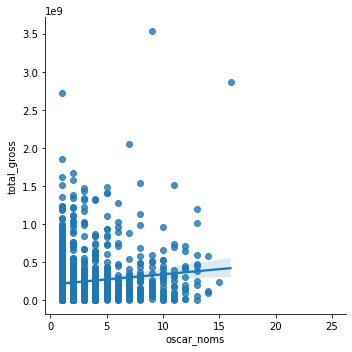

In [21]:
x ='oscar_noms'
y = 'total_gross'
# drop duplicates that exist because of genre unstacking (genre not relevant for this chart)
noms_vs_budget = oscar_df.loc[:,[x, y]].drop_duplicates()
sns.lmplot(x,y, data = noms_vs_budget)

## 9. Plotting Oscar Nominations per Genre

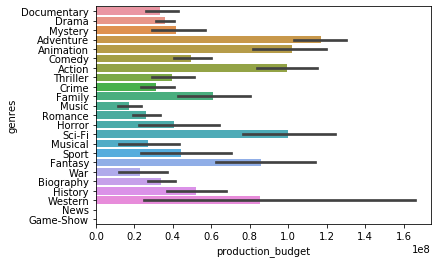

In [22]:
sns.barplot('production_budget','genres' , data = oscar_df)

# Question 2: How does Trailer Popularity impact Movie Success?
### Task: Compare movie trailer view counts to movie ratings and revenue

### Data of Interest:
- trailer views
- gross revenue
- online ratings

### Datasets:
https://grouplens.org/datasets/movielens/20m-youtube/

In [23]:
# slice year out of title string, merge with budgets table
trailers_raw = pd.read_csv('./zippedData/movie_trailers.zip')
trailers_raw['title'] = trailers_raw['title'].str[:-7]
trailers = trailers_raw.merge(budget_concat, on='title').sort_values('total_gross', ascending=False) #### remove this later
ids = list(trailers["youtubeId"].values[:])
trailers

,youtubeId,movieId,title,domestic_gross,foreign_gross,production_budget,total_gross,roi
2745,5MB3Ea6L-gw,72998,Avatar,760507625.0,2.776345e+09,425000000.0,3.536853e+09,732.20
459,yxIVO7P0iig,118916,Titanic,659363944.0,2.208208e+09,200000000.0,2.867572e+09,1333.79
458,dQ7MAigAhas,3404,Titanic,659363944.0,2.208208e+09,200000000.0,2.867572e+09,1333.79
457,2e-eXJ6HgkQ,1721,Titanic,659363944.0,2.208208e+09,200000000.0,2.867572e+09,1333.79
2799,TbQm5doF_Uc,106696,Frozen,400738009.0,1.272470e+09,150000000.0,1.673208e+09,1015.47
...,...,...,...,...,...,...,...,...
4012,myjar5KoqZA,129820,Spare Parts,3600000.0,NaN,NaN,NaN,NaN
4017,utmvmr7cgcg,130052,Clown,55000.0,NaN,NaN,NaN,NaN
4020,tRn3gr8Pt_o,130382,Mr. Pip,1700.0,NaN,NaN,NaN,NaN
4028,6uaWekLrilY,131023,That Sugar Film,3500.0,NaN,NaN,NaN,NaN


## Create function to feed in youtube id's of trailers and retrieve view counts

In [24]:

def getViews(youtubeIDs):
    views = []
    for i in youtubeIDs:
        try:
            url = "https://www.youtube.com/watch?v={}".format(i)
            html_page = requests.get(url) 
            soup = BeautifulSoup(html_page.text, 'html.parser')
            script = soup.find_all('script')[32]
            value = re.findall('ewCount":{"simpleText":"([\d,]+) views', str(soup))
            views.append(float(value[0].replace(',','')))
        except:
            views.append(0)
    return views


## Scrape all YouTube Trailers and save as CSV (Warning: takes ~1hr to run)
### Leave this commented out

In [25]:
# trailers['trailer_views'] = getViews(ids)
# trailers.to_csv('zippedData/trailerViews.csv')

# Final Trailer Views vs ROI DataFrame

In [26]:
# sort by trailer views and drop duplicates to keep only trailer with highest views
trailer_df = pd.read_csv('zippedData/trailerViews.csv')
trailer_df = trailer_df.loc[:,['title','youtubeId','production_budget', 'total_gross', 'roi', 'trailer_views']].sort_values('trailer_views', ascending=False)
trailer_df = trailer_df.drop_duplicates(subset= ['title'], keep='first').set_index('title')
trailer_df

,youtubeId,production_budget,total_gross,roi,trailer_views
title,,,,,
Unfaithful,j-V12tL78Mc,50000000.0,1.191145e+08,138.23,117290789.0
Ilo Ilo,ISovsVvX8Bg,NaN,1.156800e+06,NaN,67247941.0
Transformers: Dark of the Moon,3H8bnKdf654,195000000.0,1.123791e+09,476.30,53112332.0
The Fault in Our Stars,9ItBvH5J6ss,12000000.0,3.071668e+08,2459.72,44956623.0
Eden,pdbI0Fn4COQ,2300000.0,0.000000e+00,-100.00,43188495.0
...,...,...,...,...,...
Harry Brown,I2S3SraFmI0,7300000.0,1.202361e+07,64.71,0.0
Elles,YIWiNzszcAo,NaN,9.120000e+05,NaN,0.0
Miral,4t8E6_S9f4k,NaN,9.000000e+05,NaN,0.0


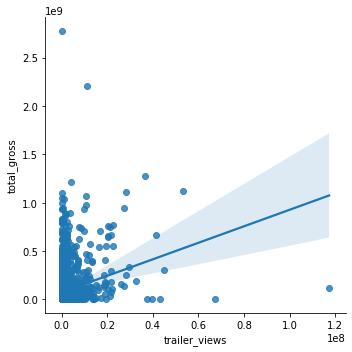

In [27]:
sns.lmplot('trailer_views', 'total_gross', data = trailer_df)

# Question 3: Do Music Scores Contribute to Movie Success?
### Task: Look at how music score ratings compare to movie ratings and ROI
### Data of Interest:
- Composers
- Music Score Rating
- Average Movie Rating
- TMDB rating
- IMDB rating
- ROI

### Datasets: 
- https://www.soundtrack.net/content/reviews/ (not sure if we will end up using this one)
- http://www.movie-wave.net/reviews-by-composer/


## Scrape music reviews page

In [ ]:
page = requests.get("http://www.movie-wave.net/reviews-by-title/")
soup = BeautifulSoup(page.content, 'html.parser')
content =soup.find('div', class_="page-content")
p_list = content.findAll('p')

In [ ]:
to_df =[]
for p in p_list:
    for a in p.findAll('a'):
        try:
           to_df.append([a.text, a.nextSibling, a.nextSibling.nextSibling.text])
        except:
            pass


## Create DataFrame with Music Ratings

In [ ]:
music_df = pd.DataFrame(to_df, columns=['title', 'composer', 'stars'])
music_df['composer'] = music_df['composer'].str[:-7]

In [ ]:
stars = list(music_df['stars'])
mapper = {'*****':5, '**** 1/2':4.5,'****':4,'*** 1/2':3.5,'***':3,'** 1/2':2.5,'**':2,'* 1/2':1.5,'*':1}
ratings = list(map(mapper.get, stars))
music_df['music_rating'] = ratings
music_df = music_df.drop('stars',axis=1)
music_df

## Merge TMDB Ratings with Budget/ROI table


In [ ]:
# Rename columns to specify TMDB, and subset data to only get columns of interest
tmdb = tmdb_raw.merge(budget_concat[['title', 'total_gross','production_budget', 'roi']], on='title', how='left')
tmdb.rename(columns ={'popularity':'tmdb_popularity', 'vote_average': 'tmdb_rating', 'vote_count': 'tmdb_votes'}, inplace=True)
tmdb = tmdb.loc[:,['title', 'tmdb_rating', 'tmdb_votes', 'tmdb_popularity', 'total_gross', 'production_budget', 'roi']]
tmdb.head()

## merge in IMDB ratings with above TMDB table

In [ ]:
# To retain as much info as possible, joined imdb_ratings with title table rather than title_basics
imdb = imdb_raw.merge(titles_raw,left_on ='tconst', right_on ='title_id')
imdb.rename(columns ={'averagerating':'imdb_rating', 'numvotes': 'imdb_votes'}, inplace=True)
imdb = imdb[['title', 'imdb_rating', 'imdb_votes' ]]
ratings = imdb.merge(tmdb, on='title', how='left')
ratings.head()

# Final Music X IMDB X TMDB X Revenue Table

In [ ]:
final_music = music_df.merge(ratings, on='title', how='inner')


In [ ]:
final_music

In [ ]:
final_music.isnull().sum()


## Movie ROI's by Genre

In [ ]:
gross = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

### Clean data and Computer ROI

In [ ]:
gross['year'] = gross['release_date'].str[-4:].astype(float)
gross['domestic_gross'] = gross['domestic_gross'].str.replace(',', '')
gross['domestic_gross'] = gross['domestic_gross'].str.replace('$', '').astype(float)
gross['production_budget'] = gross['production_budget'].str.replace(',', '')
gross['production_budget'] = gross['production_budget'].str.replace('$', '').astype(float)
gross['worldwide_gross'] = gross['worldwide_gross'].str.replace(',', '')
gross['worldwide_gross'] = gross['worldwide_gross'].str.replace('$', '').astype(float)

In [ ]:
gross['ROI'] = (((gross['worldwide_gross'] - gross['production_budget']) / gross['production_budget'] ) * 100)

In [ ]:
gross.rename(columns = {'movie': 'original_title'}, inplace=True)

In [ ]:
gross.set_index('original_title')

### Stack Genre DataFrame and Merge with Financial Data

In [ ]:
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
genre_raw

genre_ugly = genre_raw
genre_ugly['genres'] = genre_ugly['genres'].str.split(',', 3)
genre_unstack = genre_ugly.set_index('original_title').genres.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
genre_unstack.columns = ['original_title', 'genres']

In [ ]:
genre_roi = genre_unstack.merge(gross[['original_title', 'ROI']], on='original_title', how='left')

In [ ]:
genre_roi.dropna(axis = 0, inplace = True)

### Bar Chart Displaying Musicals Having Highest Average ROI

In [ ]:
y = genre_roi.groupby(['genres'])['ROI'].mean()
x = y.index

figure, ax = plt.subplots(figsize = (15,7))

ax.set_title('Average ROI For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(rotation=90)

ax.bar(x, y, color='green');

##### Musicals have the highest ROI ----- notes -------- look for what composers are for what musicals

## Compiling for Composer Dataframe

### Stack Column Listing Movie IDs for Each Crew Member

In [ ]:
crew_raw = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
crew_raw

crew = crew_raw
crew['directors'] = crew['directors'].str.split(',', 5)
crew_unstack = crew.set_index('tconst').directors.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
crew_unstack.columns = ['tconst', 'id']

### Stack Column Listing Roles a Crew Member Held in Production

In [ ]:
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
name_basics_raw.rename(columns = {'nconst' : 'directors', 'title_id':'tconst'}, inplace=True)
name_basics_raw

name_basics = name_basics_raw
name_basics['primary_profession'] = name_basics['primary_profession'].str.split(',', 5)
name_basics_unstack = name_basics.set_index('directors').primary_profession.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()

In [ ]:
name_basics_unstack.columns = ['id', 'job_title']

In [ ]:
name_basics.rename(columns={'directors':'id'}, inplace=True)

#### Pulling in Data and Matching indices to Merge

In [ ]:
titles_raw = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
titles_raw.rename(columns = {'title_id':'tconst', 'title' : 'original_title'}, inplace=True)

In [ ]:
roi_with_title = genre_roi.merge(titles_raw[['original_title', 'tconst']], on='original_title', how='inner')
roi_with_title.drop_duplicates(inplace=True)

In [ ]:
composer = name_basics_unstack[name_basics_unstack['job_title'] == 'composer']

In [ ]:
composers = crew_unstack.merge(composer[['id', 'job_title']], on='id', how='left')
composers.dropna(inplace=True)
composers.set_index('id', inplace=True)

In [ ]:
composers_names = composer.merge(name_basics[['id', 'primary_name']], on='id', how='left')

In [ ]:
composers_names.set_index('primary_name')

In [ ]:
crew = crew_unstack.merge(name_basics_raw[['id', 'primary_name']], on='id', how='left')

In [ ]:
roi_crew_genre = roi_with_title.merge(crew[['tconst', 'primary_name']], on='tconst', how='left')
roi_crew_genre.drop_duplicates(inplace=True)
roi_crew_genre.set_index('primary_name')

In [ ]:
composer_ = roi_crew_genre.merge(composers_names[['job_title', 'primary_name']], on='primary_name', how='inner')

In [ ]:
imdb_raw = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')

In [ ]:
composer_df = composer_.merge(imdb_raw[['tconst', 'averagerating']], on='tconst', how='left')
composer_df.rename(columns={'primary_name': 'composer'}, inplace=True)
composer_df.set_index('composer', inplace=True)

In [ ]:
music_df.set_index('composer', inplace=True)

In [ ]:
### can look at how the music rating varies from the overall movie rating

In [ ]:
ratings.head()

In [ ]:
music_df.head()

In [ ]:
music_movie_ratings = music_df.merge(composer_df[['averagerating']], on='composer', how='left')

In [ ]:
music_movie_ratings

In [ ]:
music_movie_ratings.isnull().sum()

In [ ]:
### There is no overlap ughhhhhhhhhhhhfusbcisnicsifnc

In [ ]:
composer_df

In [ ]:
composer_df.ROI.mean()

In [ ]:
composer_df.ROI.std()

In [ ]:
ratings.roi.mean()

In [ ]:
ratings.roi.std()

##### composer dataframe has higher mean but also higher std




In [ ]:
### did a movie with a composer do better than the overall average ratings?

In [ ]:
figure, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].set_title('Rating For Composers Only')
ax[0].set_xlabel('')
ax[0].set_ylabel('')

y = composer_df.averagerating

ax[0].hist(y);

ax[1].set_title('Overall Rating Total')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

y = ratings.imdb_rating

ax[1].hist(y);

In [ ]:
#### we should get the mean and standard dev
composer_df['averagerating'].mean()

In [ ]:
ratings['imdb_rating'].mean()

In [ ]:
composer_df['averagerating'].std()

In [ ]:
ratings['imdb_rating'].std()

### INSIGHTS -------
#### mean is slightly higher and std dev is lower for the composers than overall

In [ ]:
y = genre_roi.groupby(['genres'])['ROI'].mean()
x = y.index

figure, ax = plt.subplots(figsize = (15,7))

ax.set_title('Average ROI For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(rotation=90)

ax.bar(x, y, color='green');

In [ ]:
y = genre_roi.groupby(['genres'])['ROI'].std()
x = y.index

figure, ax = plt.subplots(figsize = (15,7))

ax.set_title('ROI Standard Deviation For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(rotation=90)

ax.bar(x, y, color='green');

In [ ]:
genre_roi[genre_roi['genres'] == 'Musical']['ROI'].mean()

In [ ]:
genre_roi[genre_roi['genres'] == 'Musical']['ROI'].std()

In [ ]:
genre_roi[genre_roi['genres'] == 'Horror']['ROI'].mean()

In [ ]:
genre_roi[genre_roi['genres'] == 'Horror']['ROI'].std()

In [ ]:
genre_roi[genre_roi['genres'] == 'Mystery']['ROI'].mean()

In [ ]:
genre_roi[genre_roi['genres'] == 'Mystery']['ROI'].std()

## The top three Average ROIs have the highest standard dev

In [ ]:
### could look into how much better the remake did  for musicals -- wait only 6 remakes though